In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import torchaudio
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Configuration
DATA_PATH = '/home/akshay/project_EE708/Music Genre Classification/Train'
SAMPLE_RATE = 22050
DURATION = 30  # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
NUM_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512
NUM_SEGMENTS = 5
SEGMENT_DURATION = 6
SEGMENT_SAMPLES = SAMPLE_RATE * SEGMENT_DURATION
BATCH_SIZE = 64
EPOCHS = 50  
IMG_SIZE = (256, 256)
LEARNING_RATE = 0.0007

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("No GPUs found. Running on CPU.")

# Mapping class names to indices
CLASSES = [
    'blues', 'classical', 'country', 'disco', 'hiphop',
    'jazz', 'metal', 'pop', 'reggae', 'rock'
]
CLASS_MAPPING = {class_name: i for i, class_name in enumerate(CLASSES)}
INV_CLASS_MAPPING = {i: class_name for class_name, i in CLASS_MAPPING.items()}

Using device: cuda
GPU: NVIDIA GeForce RTX 3080
Available GPU memory: 10.38 GB


In [6]:
# Define dataset class


class OnTheFlyMusicGenreDataset(Dataset):
    def __init__(self, file_list, segment_indices, transform=None, mode='train'):
        self.file_list = file_list
        if '/home/akshay/project_EE708/Music Genre Classification/Train/jazz/jazz.00054.wav' in self.file_list:
            self.file_list.remove('/home/akshay/project_EE708/Music Genre Classification/Train/jazz/jazz.00054.wav')
        self.segment_indices = segment_indices
        self.transform = transform
        self.mode = mode
        
        # Audio transforms
        self.mel_spectrogram = MelSpectrogram(
            sample_rate=SAMPLE_RATE,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            n_mels=128,
            f_min=20,
            f_max=8000
        )
        self.amplitude_to_db = AmplitudeToDB()
        
    def __len__(self):
        return len(self.segment_indices)
    
    def _load_audio(self, file_path):
        """Load and preprocess audio file"""
        # print('loading')
        try:
            waveform, sr = torchaudio.load(file_path)
        except:
            print('----------')
            print(file_path)
            print('----------')
            sr = 44100
            return torch.ones((1,int(sr*10)))
        # print('loaded')
        # Resample if necessary
        if sr != SAMPLE_RATE:
            resampler = torchaudio.transforms.Resample(sr, SAMPLE_RATE)
            waveform = resampler(waveform)
            
        # Ensure correct length
        if waveform.shape[1] < SAMPLES_PER_TRACK:
            padding = SAMPLES_PER_TRACK - waveform.shape[1]
            waveform = F.pad(waveform, (0, padding))
        else:
            waveform = waveform[:, :SAMPLES_PER_TRACK]
            
        return waveform.squeeze()

    def _extract_features(self, waveform):
        """Extract mel spectrogram features"""
        # Generate mel spectrogram
        mel_spec = self.mel_spectrogram(waveform)
        
        # Convert to dB scale
        log_mel_spec = self.amplitude_to_db(mel_spec)
        
        # Resize to target dimensions
        log_mel_spec = torch.tensor(
            np.resize(log_mel_spec.numpy(), IMG_SIZE)
        )
        
        # Normalize
        log_mel_spec = (log_mel_spec - log_mel_spec.mean()) / (log_mel_spec.std() + 1e-10)
        
        return log_mel_spec.unsqueeze(0)  # Add channel dimension

    def __getitem__(self, idx):
        file_idx, segment_idx = self.segment_indices[idx]
        file_path, label = self.file_list[file_idx]
        
        # Load audio
        waveform = self._load_audio(file_path)
        
        # Extract segment
        start_sample = segment_idx * SEGMENT_SAMPLES
        end_sample = start_sample + SEGMENT_SAMPLES
        segment = waveform[start_sample:end_sample]
        
        # Extract features
        features = self._extract_features(segment)
        
        # Apply transforms if available
        if self.transform and self.mode == 'train':
            features = self.transform(features)
            
        return features.float(), torch.tensor(label, dtype=torch.long)


In [7]:
# Model architecture


class CNNModel(nn.Module):
    """Hybrid CNN-Transformer with Multi-Head Self Attention"""
    
    def __init__(self, num_classes=len(CLASSES), num_heads=4, embed_dim=256):
        super().__init__()
        self.embed_dim = embed_dim
        
        # Convolutional Feature Extractor
        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            # Block 2 with attention
            ResidualBlock(64, 128, downsample=True),
            SelfAttentionBlock(128, num_heads),
            
            # Block 3 with attention
            ResidualBlock(128, embed_dim, downsample=True),
            SelfAttentionBlock(embed_dim, num_heads),
            
            nn.Dropout(0.4)
        )
        
        # Transformer Encoder
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=embed_dim*4,
                dropout=0.3,
                activation='gelu',
                batch_first=True
            ),
            num_layers=2
        )
        
        # Adaptive pooling and classifier
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, embed_dim*2),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(embed_dim*2, num_classes)
        )

    def forward(self, x):
        # Convolutional features
        x = self.conv_layers(x)  # [B, 256, H', W']
        
        # Prepare for transformer
        b, c, h, w = x.size()
        x = x.view(b, c, h*w).permute(0, 2, 1)  # [B, seq_len, embed_dim]
        
        # Transformer processing
        x = self.transformer(x)
        
        # Pooling and classification
        x = x.mean(dim=1)  # Global average pooling
        return self.classifier(x)

class ResidualBlock(nn.Module):
    """Residual block with depthwise separable convolutions"""
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, stride, 1, groups=in_channels),
            nn.Conv2d(in_channels, out_channels, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Dropout(0.3)
        )
        
        self.shortcut = nn.Sequential()
        if in_channels != out_channels or downsample:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        return self.conv(x) + self.shortcut(x)

class SelfAttentionBlock(nn.Module):
    """Multi-head self attention with positional encoding"""
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(
            embed_dim, 
            num_heads,
            dropout=0.2,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim*4),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(embed_dim*4, embed_dim)
        )
        
        # Learnable scale parameter for attention contribution
        self.alpha = nn.Parameter(torch.tensor(0.1))

    def forward(self, x):
        B, C, H, W = x.size()
        x_flat = x.view(B, C, H*W).permute(0, 2, 1)
        
        # Self-attention with residual
        attn_out, _ = self.attn(x_flat, x_flat, x_flat)
        x = x + self.alpha * attn_out.permute(0, 2, 1).view_as(x)
        
        # Feedforward with residual
        x_flat = x.view(B, C, H*W).permute(0, 2, 1)
        x = x + self.ffn(self.norm(x_flat)).permute(0, 2, 1).view_as(x)
        return x



In [8]:
def prepare_test_dataset(data_path):
    """Prepare test dataset by collecting all audio files with their labels"""
    file_list = []
    for class_name in CLASSES:
        class_dir = os.path.join(data_path, class_name)
        if os.path.isdir(class_dir):
            for f in os.listdir(class_dir):
                if f.endswith('.wav'):
                    file_path = os.path.join(class_dir, f)
                    file_list.append((file_path, CLASS_MAPPING[class_name]))
    
    # Generate segment indices
    segment_indices = []
    for file_idx, (file_path, label) in enumerate(file_list):
        for seg_idx in range(NUM_SEGMENTS):
            segment_indices.append((file_idx, seg_idx))
    
    # Create dataset
    test_dataset = OnTheFlyMusicGenreDataset(file_list, segment_indices)
    
    return test_dataset, file_list

# Prepare test dataset
test_dataset, file_list = prepare_test_dataset(DATA_PATH)

# Create test dataloader
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Total test files: {len(file_list)}")
print(f"Total test segments: {len(test_dataset)}")

Total test files: 799
Total test segments: 3995


In [9]:
# Load the model
model = CNNModel().to(device)
try:
    model.load_state_dict(torch.load('models/best_model.pth', map_location=device))
    print("Model loaded successfully")
except Exception as e:
    print(f"Error loading model: {e}")

# Print model summary
print("\nModel Architecture:")
print(model)

Model loaded successfully

Model Architecture:
CNNModel(
  (conv_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): ResidualBlock(
      (conv): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64)
        (1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): GELU(approximate='none')
        (4): Dropout(p=0.3, inplace=False)
      )
      (shortcut): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (5): SelfAttentionBlock(
      (norm): L

In [10]:
# Evaluate the model
def evaluate_model(model, test_loader, device):
    """Evaluate model performance on test data"""
    model.eval()
    all_preds = []
    all_labels = []
    all_file_indices = []
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            # Get the file_indices from segment_indices for this batch
            batch_segment_indices = test_loader.dataset.segment_indices[
                batch_idx * test_loader.batch_size:
                min((batch_idx + 1) * test_loader.batch_size, len(test_loader.dataset))
            ]
            batch_file_indices = [idx[0] for idx in batch_segment_indices]
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_file_indices.extend(batch_file_indices)
    
    # For songs with multiple segments, use majority voting
    file_preds = {}
    file_labels = {}
    
    for i, file_idx in enumerate(all_file_indices):
        if file_idx not in file_preds:
            file_preds[file_idx] = []
            # Get the true label from the file_list
            file_labels[file_idx] = test_loader.dataset.file_list[file_idx][1]
        
        file_preds[file_idx].append(all_preds[i])
    
    # Apply majority voting for each file
    final_preds = []
    final_labels = []
    
    for file_idx, predictions in file_preds.items():
        # Get the most common prediction for this file
        unique_preds, counts = np.unique(predictions, return_counts=True)
        majority_pred = unique_preds[np.argmax(counts)]
        
        final_preds.append(majority_pred)
        final_labels.append(file_labels[file_idx])
    
    # Calculate metrics
    accuracy = accuracy_score(final_labels, final_preds)
    precision = precision_score(final_labels, final_preds, average="weighted", zero_division=0)
    recall = recall_score(final_labels, final_preds, average="weighted", zero_division=0)
    f1 = f1_score(final_labels, final_preds, average="weighted", zero_division=0)
    
    # Generate classification report
    class_names = [INV_CLASS_MAPPING[i] for i in range(len(CLASSES))]
    report = classification_report(final_labels, final_preds, target_names=class_names, zero_division=0)
    
    # Confusion matrix
    cm = confusion_matrix(final_labels, final_preds)
    
    return accuracy, precision, recall, f1, report, cm, class_names

# Set model to evaluation mode
model.eval()

# Evaluate the model
accuracy, precision, recall, f1, report, cm, class_names = evaluate_model(model, test_loader, device)

# Print evaluation metrics
print(f"\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print classification report
print("\nClassification Report:\n", report)


Model Evaluation Metrics:
Accuracy: 0.9875
Precision: 0.9877
Recall: 0.9875
F1 Score: 0.9875

Classification Report:
               precision    recall  f1-score   support

       blues       1.00      0.99      0.99        80
   classical       1.00      0.99      0.99        80
     country       0.99      1.00      0.99        80
       disco       0.98      0.99      0.98        80
      hiphop       0.95      0.99      0.97        80
        jazz       0.99      1.00      0.99        79
       metal       1.00      1.00      1.00        80
         pop       0.99      0.96      0.97        80
      reggae       1.00      0.97      0.99        80
        rock       0.99      0.99      0.99        80

    accuracy                           0.99       799
   macro avg       0.99      0.99      0.99       799
weighted avg       0.99      0.99      0.99       799



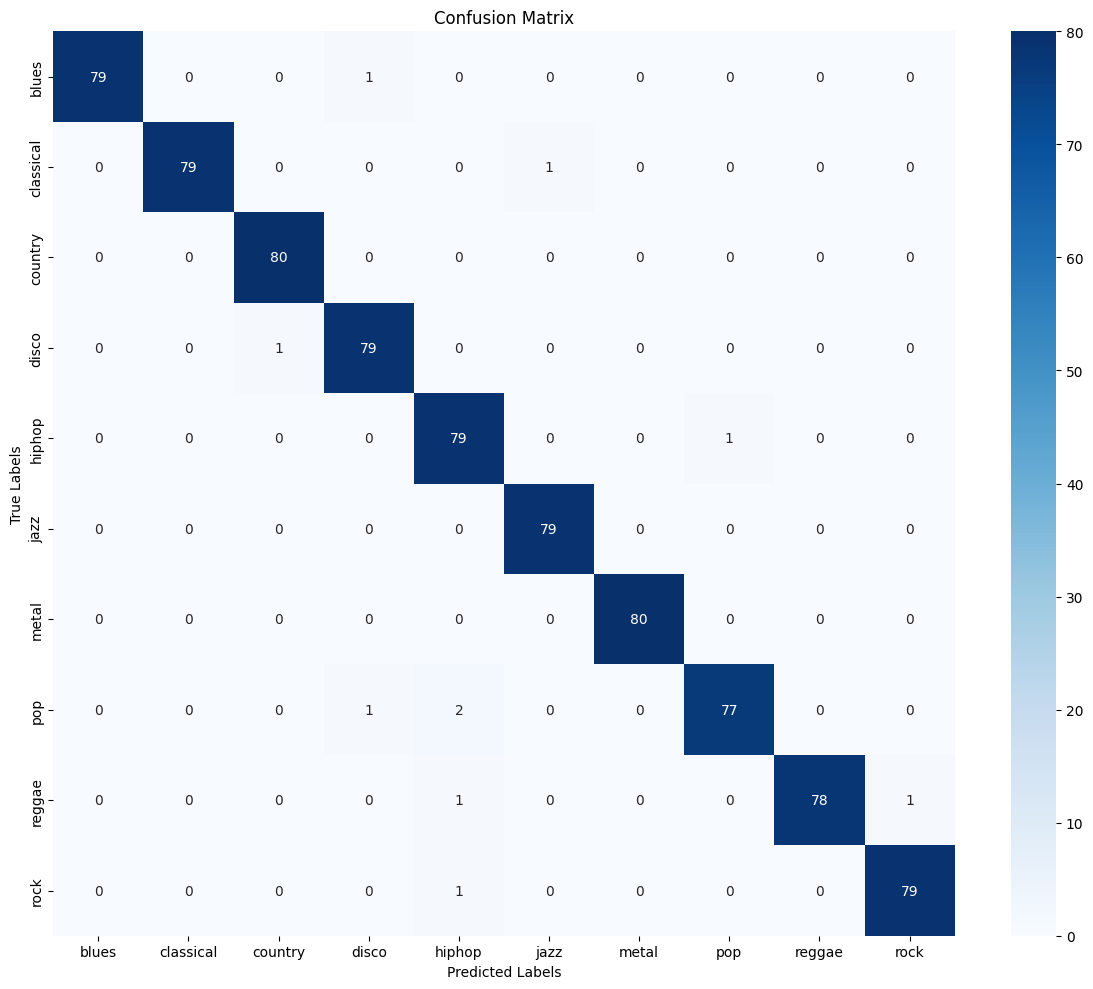

In [11]:
# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

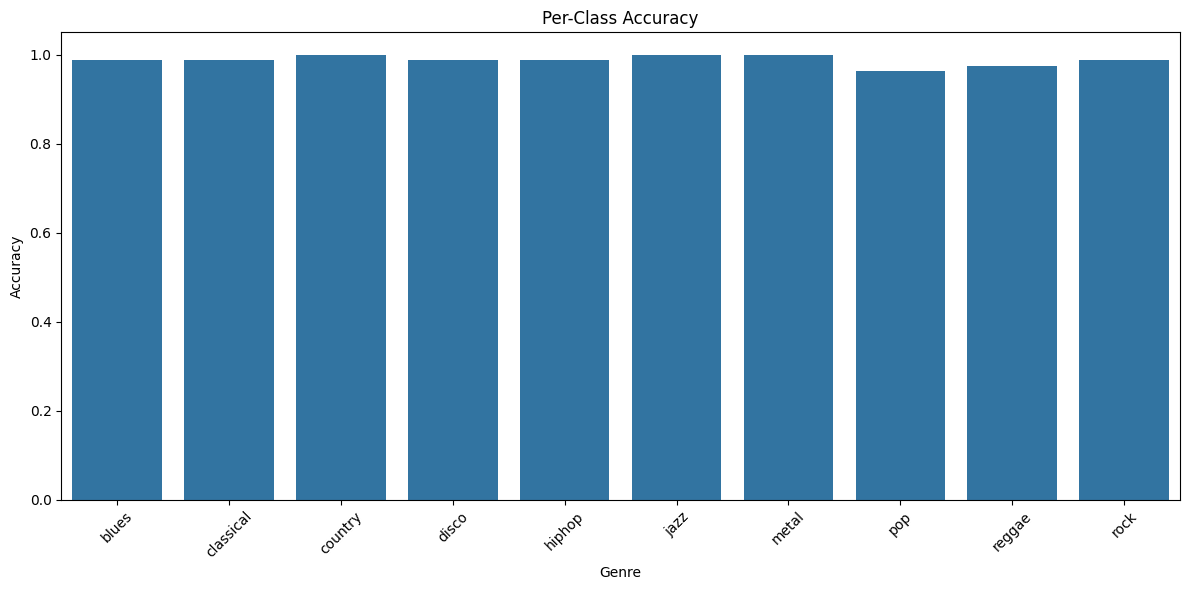

In [12]:
# Calculate and plot per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(12, 6))
sns.barplot(x=class_names, y=class_accuracy)
plt.xlabel("Genre")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("per_class_accuracy.png")
plt.show()